In [2]:
%load_ext rpy2.ipython


In [3]:
%%R
lapply(c("dplyr","Seurat","HGNChelper","openxlsx"), library, character.only = T)

load('../data/reference.RData')

sample_meta<-'AD_HS_00001	Molecular characterization of selectively vulnerable neurons in Alzheimer’s Disease	20	H.Sapiens	AD	Superior frontal gyrus;Superior frontal gyrus;Superior frontal gyrus;Superior frontal gyrus;Superior frontal gyrus;Superior frontal gyrus;Superior frontal gyrus;Superior frontal gyrus;Superior frontal gyrus;Superior frontal gyrus;Entorhinal cortex;Entorhinal cortex;Entorhinal cortex;Entorhinal cortex;Entorhinal cortex;Entorhinal cortex;Entorhinal cortex;Entorhinal cortex;Entorhinal cortex;Entorhinal cortex	Braak:0;0;0;2;2;2;2;6;6;6;0;0;0;2;2;2;2;6;6;6	ExcitatoryNeuron;InhibitoryNeuron;Oligodendrocyte;OPC;Astrocyte;Microglia;Endothelia;Pericyte	GSE147528	Single-nucleus RNA-seq	10x Genomics	Male	60;50;71;72;87;91;77;82;72;82;60;50;71;72;87;91;77;82;72;82	SRR11422700;SRR11422701;SRR11422702;SRR11422703;SRR11422704;SRR11422705;SRR11422706;SRR11422707;SRR11422708;SRR11422709;SRR11422710;SRR11422711;SRR11422712;SRR11422713;SRR11422714;SRR11422715;SRR11422716;SRR11422717;SRR11422718;SRR11422719'
split_meta<-unlist(strsplit(sample_meta, '\t'))
samples<-unlist(strsplit(split_meta[14],';'))
disease<-rep(split_meta[5],length(samples))
stage<-unlist(strsplit(unlist(strsplit(split_meta[7],':'))[2],';'))
gender<-rep(split_meta[12],length(samples))
age<-unlist(strsplit(split_meta[13],';'))

sample_meta<-data.frame(samples=samples,disease=disease,stage=stage,gender=gender,age=age)
sample_meta[sample_meta$stage=='0','disease']<-'Control'
rownames(sample_meta)<-sample_meta$samples

In [19]:
%%R
# args <- commandArgs(trailingOnly=TRUE)
args<-c('../data/3/scte','../data/3/cell_umap.txt','SRR11422700','/home/wdeng3/workspace/software/sc-type','../../universal_data/rmsk/rmsk_GRCh38.txt')
data_path<-args[1]
out_path<-args[2]
sample_tag<-args[3]
sctype_path<-args[4]
rmsk_path<-args[5]
rmsk<-read.table(rmsk_path,sep='\t',header=F)
reps<-unique(rmsk$V11)
reps<-str_replace_all(reps,'-','\\.')

create_seurat<-function(sample_tag){
    ## load data
    scte.data <- t(read.csv(paste0(data_path,'/',sample_tag,'/',sample_tag,'.csv'),check.names=F, row.names = 1))
    # remove repeats from gene expression matrix

    scte.gene<-scte.data[!(row.names(scte.data) %in% reps),]
    # normalize and scale data
    scte <- CreateSeuratObject(counts = scte.gene, project = sample_tag, min.cells = 3, min.features = 200)
    # normalize data
    scte[["percent.mt"]] <- PercentageFeatureSet(scte, pattern = "^MT.|^MT-")
    scte <- subset(scte, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
    scte <- SCTransform(scte, vars.to.regress = "percent.mt", verbose = FALSE)

    cell_meta<-scte@meta.data
    cell_meta$disease<-sample_meta[cell_meta$orig.ident,'disease']

    cell_meta$stage<-sample_meta[cell_meta$orig.ident,'stage']
    cell_meta$gender<-sample_meta[cell_meta$orig.ident,'gender']
    cell_meta$age<-sample_meta[cell_meta$orig.ident,'age']
    scte@meta.data<-cell_meta
    scte
}



scte<-create_seurat(sample_tag)

scte <- FindVariableFeatures(scte, selection.method = "vst", nfeatures = 2000)
# scale and run PCA
scte <- ScaleData(scte, features = rownames(scte))
scte <- RunPCA(scte, features = VariableFeatures(object = scte))

sdv<-Stdev(scte,reduction='pca')
sdv<-sdv[sdv>2]
npca<-length(sdv)

scte <- FindNeighbors(scte, dims = 1:npca)
scte <- FindClusters(scte, resolution = 0.8)
scte <- RunUMAP(scte, dims = 1:npca)




In [24]:
%%R
scte.anchors <- FindTransferAnchors(reference = reference, query = scte,
    dims = 1:30, reference.reduction = "pca")
scte.query <- MapQuery(anchorset = scte.anchors, reference = reference, query = scte,
    refdata = list(celltype = "broad.cell.type"), reference.reduction = "pca", reduction.model = "umap")
cell_meta<-scte.query@meta.data
cell_meta$disease<-sample_meta[cell_meta$orig.ident,'disease']

cell_meta$stage<-sample_meta[cell_meta$orig.ident,'stage']
cell_meta$gender<-sample_meta[cell_meta$orig.ident,'gender']
cell_meta$age<-sample_meta[cell_meta$orig.ident,'age']
scte.query@meta.data<-cell_meta

R[write to console]: Normalizing query using reference SCT model

R[write to console]: Projecting cell embeddings

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1634 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 846 anchors

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[wri

  |                                                  | 0 % ~calculating  

R[write to console]: 
Integrating dataset 2 with reference dataset

R[write to console]: Finding integration vectors

R[write to console]: Integrating data



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02s  


R[write to console]: Computing nearest neighbors

R[write to console]: Running UMAP projection

R[write to console]: 17:50:34 Read 4275 rows

R[write to console]: 17:50:34 Processing block 1 of 1

R[write to console]: 17:50:34 Commencing smooth kNN distance calibration using 1 thread
R[write to console]:  with target n_neighbors = 30

R[write to console]: 17:50:35 Initializing by weighted average of neighbor coordinates using 1 thread

R[write to console]: 17:50:35 Commencing optimization for 67 epochs, with 128250 positive edges

R[write to console]: Using method '
R[write to console]: umap
R[write to console]: '
R[write to console]: 

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]:

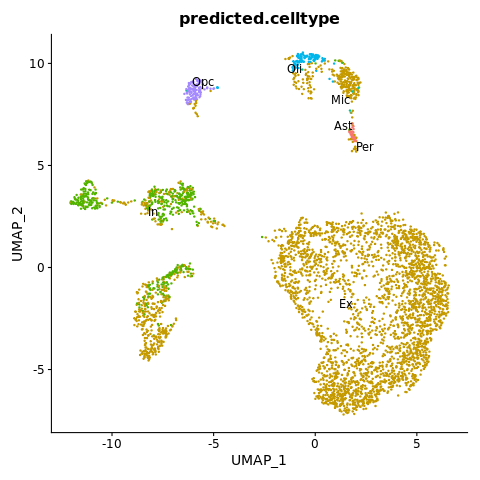

In [25]:
%%R
DimPlot(scte.query, reduction = "umap", group.by = "predicted.celltype", label = TRUE, repel = TRUE, pt.size = 0.5) + NoLegend()

In [32]:
%%R
cell_meta<-scte.query@meta.data
cell_meta$UMAP_1<-scte.query@reductions[['umap']]@cell.embeddings[rownames(cell_meta),1]
cell_meta$UMAP_2<-scte.query@reductions[['umap']]@cell.embeddings[rownames(cell_meta),2]
write.table(cell_meta,file=out_path,sep='\t',quote=F,row.names=T)

In [33]:
%%R
head(cell_meta)

                  orig.ident nCount_RNA nFeature_RNA percent.mt nCount_SCT
AAAAAACTCCAACCAA SRR11422700       1016          626   2.755906       1229
AAAACTCAGACAAAGG SRR11422700       1185          707   2.531646       1314
AAAACTCAGCGTTTAC SRR11422700        901          660   4.328524       1112
AAAATAGTCAACACGT SRR11422700       1390          980   2.230216       1417
AAACACTTCACTTACT SRR11422700        897          672   2.006689       1094
AAACATGAGCGTCAAG SRR11422700       1553          977   2.124920       1544
                 nFeature_SCT disease stage gender age SCT_snn_res.0.8
AAAAAACTCCAACCAA          624 Control     0   Male  60               5
AAAACTCAGACAAAGG          706 Control     0   Male  60               5
AAAACTCAGCGTTTAC          660 Control     0   Male  60               4
AAAATAGTCAACACGT          979 Control     0   Male  60               0
AAACACTTCACTTACT          670 Control     0   Male  60               7
AAACATGAGCGTCAAG          974 Control     0   Mal

In [39]:
import sys
import pandas as pd

sys.argv=['th','../data/3/cell_umap.txt','../www/mysql/cell_umap.sql']
out_path=sys.argv[2]
cell_umap=pd.read_csv(sys.argv[1],sep='\t',index_col=0)
cell_umap.head()

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,disease,stage,gender,age,SCT_snn_res.0.8,seurat_clusters,predicted.celltype.score,predicted.celltype,UMAP_1,UMAP_2
AAAAAACTCCAACCAA,SRR11422700,1016,626,2.755906,1229,624,Control,0,Male,60,5,5,1.000000,Ex,4.695153,-5.782813
AAAACTCAGACAAAGG,SRR11422700,1185,707,2.531646,1314,706,Control,0,Male,60,5,5,1.000000,Ex,4.223470,-3.431532
AAAACTCAGCGTTTAC,SRR11422700,901,660,4.328524,1112,660,Control,0,Male,60,4,4,0.994430,Ex,2.578369,0.869512
AAAATAGTCAACACGT,SRR11422700,1390,980,2.230216,1417,979,Control,0,Male,60,0,0,1.000000,Ex,4.285317,-3.200884
AAACACTTCACTTACT,SRR11422700,897,672,2.006689,1094,670,Control,0,Male,60,7,7,0.995993,Ex,2.809201,-2.461044


In [41]:
data_cellumap=open(out_path,'w')
data_cellumap.write('''CREATE DATABASE IF NOT EXISTS scARE;
USE scARE;
DROP TABLE IF EXISTS DATA_CELLUMAP;
CREATE TABLE DATA_CELLUMAP (
    ID INT NOT NULL AUTO_INCREMENT,
    DATASET varchar(255) NOT NULL,
    CELL varchar(255) NOT NULL,
    CELL_TYPE varchar(255) NOT NULL,
    UMAP_1 FLOAT NOT NULL,
    UMAP_2 FLOAT NOT NULL,
    PRIMARY KEY (ID) 
);
''')


import tqdm

for cell in tqdm.tqdm(cell_umap.index):
    dataset,cell_type,umap_1,umap_2=cell_umap.loc[cell,['orig.ident','predicted.celltype','UMAP_1','UMAP_2']]
    data_cellumap.write(f'INSERT INTO DATA_CELLUMAP (DATASET,CELL,CELL_TYPE,UMAP_1,UMAP_2) values({dataset},{cell},{cell_type},{umap_1},{umap_2});\n')
data_cellumap.close()


100%|██████████| 4275/4275 [00:02<00:00, 1741.57it/s]


In [ ]:
# ## assign cell type according to ScType tuturial

## load sc type and database
# source(paste0(sctype_path,"/R/gene_sets_prepare.R"))
# source(paste0(sctype_path,"/R/sctype_score_.R"))
# gs_list = gene_sets_prepare(paste0(sctype_path,'/ScTypeDB_full.xlsx'), "Brain" )
# # get cell-type by cell matrix
# es.max = sctype_score(scRNAseqData = scte[["RNA"]]@scale.data, scaled = TRUE, 
#                       gs = gs_list$gs_positive, gs2 = gs_list$gs_negative) 

# # merge by cluster
# cL_resutls = do.call("rbind", lapply(unique(scte@meta.data$seurat_clusters), function(cl){
#     es.max.cl = sort(rowSums(es.max[ ,rownames(scte@meta.data[scte@meta.data$seurat_clusters==cl, ])]), decreasing = !0)
#     head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(scte@meta.data$seurat_clusters==cl)), 10)
# }))
# sctype_scores = cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  

# # set low-confident (low ScType score) clusters to "unknown"
# sctype_scores$type[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "Unknown"


# scte@meta.data$customclassif = ""
# for(j in unique(sctype_scores$cluster)){
#   cl_type = sctype_scores[sctype_scores$cluster==j,]; 
#   scte@meta.data$customclassif[scte@meta.data$seurat_clusters == j] = as.character(cl_type$type[1])
# }

# ## save cell type
# cell_types<-scte[['customclassif']]
